## Sucesses and Failures of Hartree-Fock


In this example, we will quantify the different sources for error of the Hartree Fock method on the example of the H$_2$ molecule.

In [1]:
from ase.build import molecule
from ase.atoms import Atoms
import numpy as np
import matplotlib.pyplot as plt
import psi4
from psi4_helper import geom_ase_to_psi4

diatomic = 'H2'

In [2]:
print('.', end='')
atoms = Atoms(diatomic)
atoms.positions[1,2] = 1.5
geom_input = geom_ase_to_psi4(atoms, charge=0, multiplicity=1)
  #initiate Psi4 molecule object
h2 = psi4.geometry(geom_input)

  # Set computation options
psi4.set_options({'basis': '3-21G',
                  'reference': 'rhf',
                  'scf_type':'pk',
                  #'frozen_docc': [0],
                  #'active':[4],
                  #'frozen_uocc': [0],
                  'e_convergence': 1e-8})
E,wfn = psi4.energy('scf',return_wfn=True)
psi4.molden(wfn,'c2.molden')

.

In [5]:
psi4.core.clean()
psi4.core.set_output_file('output.dat', False)
psi4.set_memory('6000 MB')

distances = [0.4,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.4,1.8,2.2,3.0,3.5,4.5,6,10.]

E_HF = []
E_exact = []

for i in distances:
  print('. ', end='')
  atoms = Atoms(diatomic)
  atoms.positions[1,2] = i
  geom_input = geom_ase_to_psi4(atoms, charge=0, multiplicity=1)
  #initiate Psi4 molecule object
  h2 = psi4.geometry(geom_input)

  # Set computation options
  psi4.set_options({'basis': '3-21G',
                  'reference': 'rhf',
                  'scf_type':'direct',
                  'frozen_docc': [0],
                  'active':[2],
                  'frozen_uocc': [0],
                  'ci_maxiter': 100,
                  'e_convergence': 1e-8})

  E_HF.append(psi4.energy('scf',return_wfn=False))
  E_exact.append(psi4.energy('fci',return_wfn=False))
  print (i, E_HF[-1], E_exact[-1])

print('calculations finished!')
#for x, i,j in zip(distances,E_HF, E_exact):
#    print(x, i,j)

. 0.4 -0.922872182813211 -0.9413883500883244
. 0.6 -1.1047213280024517 -1.1269305625446417
. 0.7 -1.1219949533964786 -1.146062180887005
. 0.8 -1.1202128149279282 -1.1463997840787477
. 0.9 -1.1083634872577317 -1.137107633777373
. 1.0 -1.0913860704971088 -1.1232535033166213
. 1.1 -1.0720456469379918 -1.1076907356944454
. 1.2 -1.051838502868617 -1.0919767233031057
. 1.4 -1.011593194168383 -1.0630214547204004
. 1.8 -0.9388546396415101 -1.0219611915604867
. 2.2 -0.8803961201743079 -1.0026236028173163
. 3.0 -0.8024822323089528 -0.9933673529522534
. 3.5 -0.7743818395605917 -0.9925966789115246
. 4.5 -0.7463701010590946 -0.9924009255287386
. 6 -0.7301049490790654 -0.992397219306024
. 10.0 -0.7124479545407323 -0.9923972187618811
calculations finished!


<IPython.core.display.Javascript object>


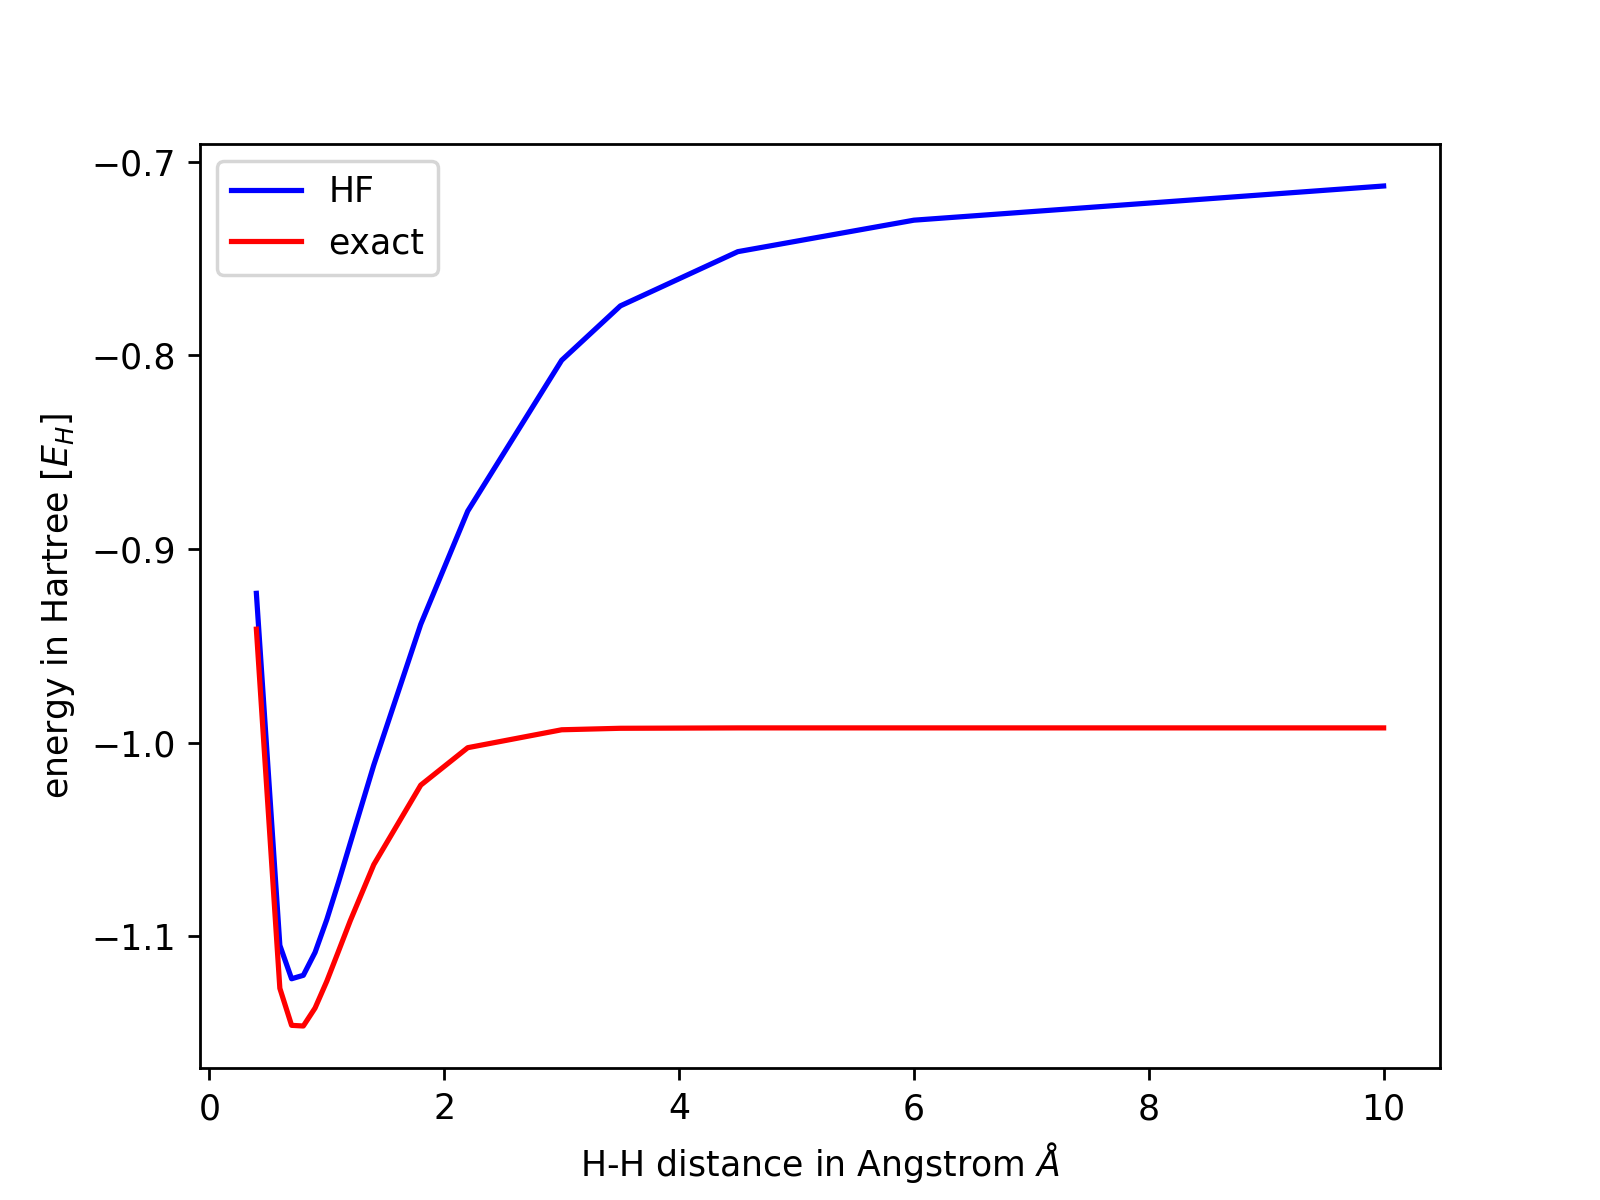

In [6]:
%matplotlib notebook
plt.plot(distances, E_HF,'b',label='HF')
plt.plot(distances, E_exact,'r',label='exact')
plt.legend()
plt.xlabel('H-H distance in Angstrom $\AA$')
plt.ylabel('energy in Hartree [$E_H$]')

The exact solution includes all possible Slater determinants and correctly describes bond breaking. This is, however, in almost all cases impossible to calculate.

We can find a solution to the correlation problem in two steps:
* first we account for static correlation in the bond breaking limit. This will treat all H-H distances equally
* Then we can include dynamic correlation

In [7]:
E_CASSCF = []

psi4.core.set_output_file('output.dat', True)
distances = [0.4,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.4,1.8,2.2,3.0,3.5,4.5,6,10.]

for i in distances:
  psi4.core.clean()
  print('. ', end='')
  atoms = Atoms(diatomic)
  atoms.positions[1,2] = i
  geom_input = geom_ase_to_psi4(atoms, charge=0, multiplicity=1)
  #initiate Psi4 molecule object
  h2 = psi4.geometry(geom_input)

  # Set computation options
  psi4.set_options({'basis': '3-21G',
                  'reference': 'rhf',
                  'scf_type': 'pk',
                  'mcscf_algorithm':'ah',
                  'qc_module': 'detci',
                  'ci_maxiter': 100,    
                    'mcscf_maxiter': 300,
                  'e_convergence': 1.e-8,
                  'num_roots':1,
                   })

  #cisd_energy, cisd_wfn = psi4.energy("cisd", return_wfn=True)
  #4 orbitals [sigma, sigma*, and two more), The first 2 of them should be active
  #That means that CASSCF should build the possible determinants from those two
  psi4.set_options({
      'restricted_docc': [0],
      'active': [2],
      'restricted_uocc':[2],
                   })
    
  E = psi4.energy('casscf')#,ref_wfn=cisd_wfn)
  print(i, E)
  E_CASSCF.append(E) 

print('calculations finished!')
#for x, i in zip(distances,E_CASSCF):
#    print(x, i)


. 0.4 -0.9338012481951736
. 0.6 -1.1202320567138933
. 0.7 -1.1402607979317767
. 0.8 -1.141597525415999
. 0.9 -1.1332766769237042
. 1.0 -1.120277767256405
. 1.1 -1.1054150160019087
. 1.2 -1.0902476038394764
. 1.4 -1.0620274288762857
. 1.8 -1.0216572734674658
. 2.2 -1.0025487623644935
. 3.0 -0.9933646375373496
. 3.5 -0.9925964031272232
. 4.5 -0.9924009234586021
. 6 -0.9923972192036687
. 10.0 -0.9923972186597102
calculations finished!
0.4 -0.9338012481951736
0.6 -1.1202320567138933
0.7 -1.1402607979317767
0.8 -1.141597525415999
0.9 -1.1332766769237042
1.0 -1.120277767256405
1.1 -1.1054150160019087
1.2 -1.0902476038394764
1.4 -1.0620274288762857
1.8 -1.0216572734674658
2.2 -1.0025487623644935
3.0 -0.9933646375373496
3.5 -0.9925964031272232
4.5 -0.9924009234586021
6 -0.9923972192036687
10.0 -0.9923972186597102


<IPython.core.display.Javascript object>


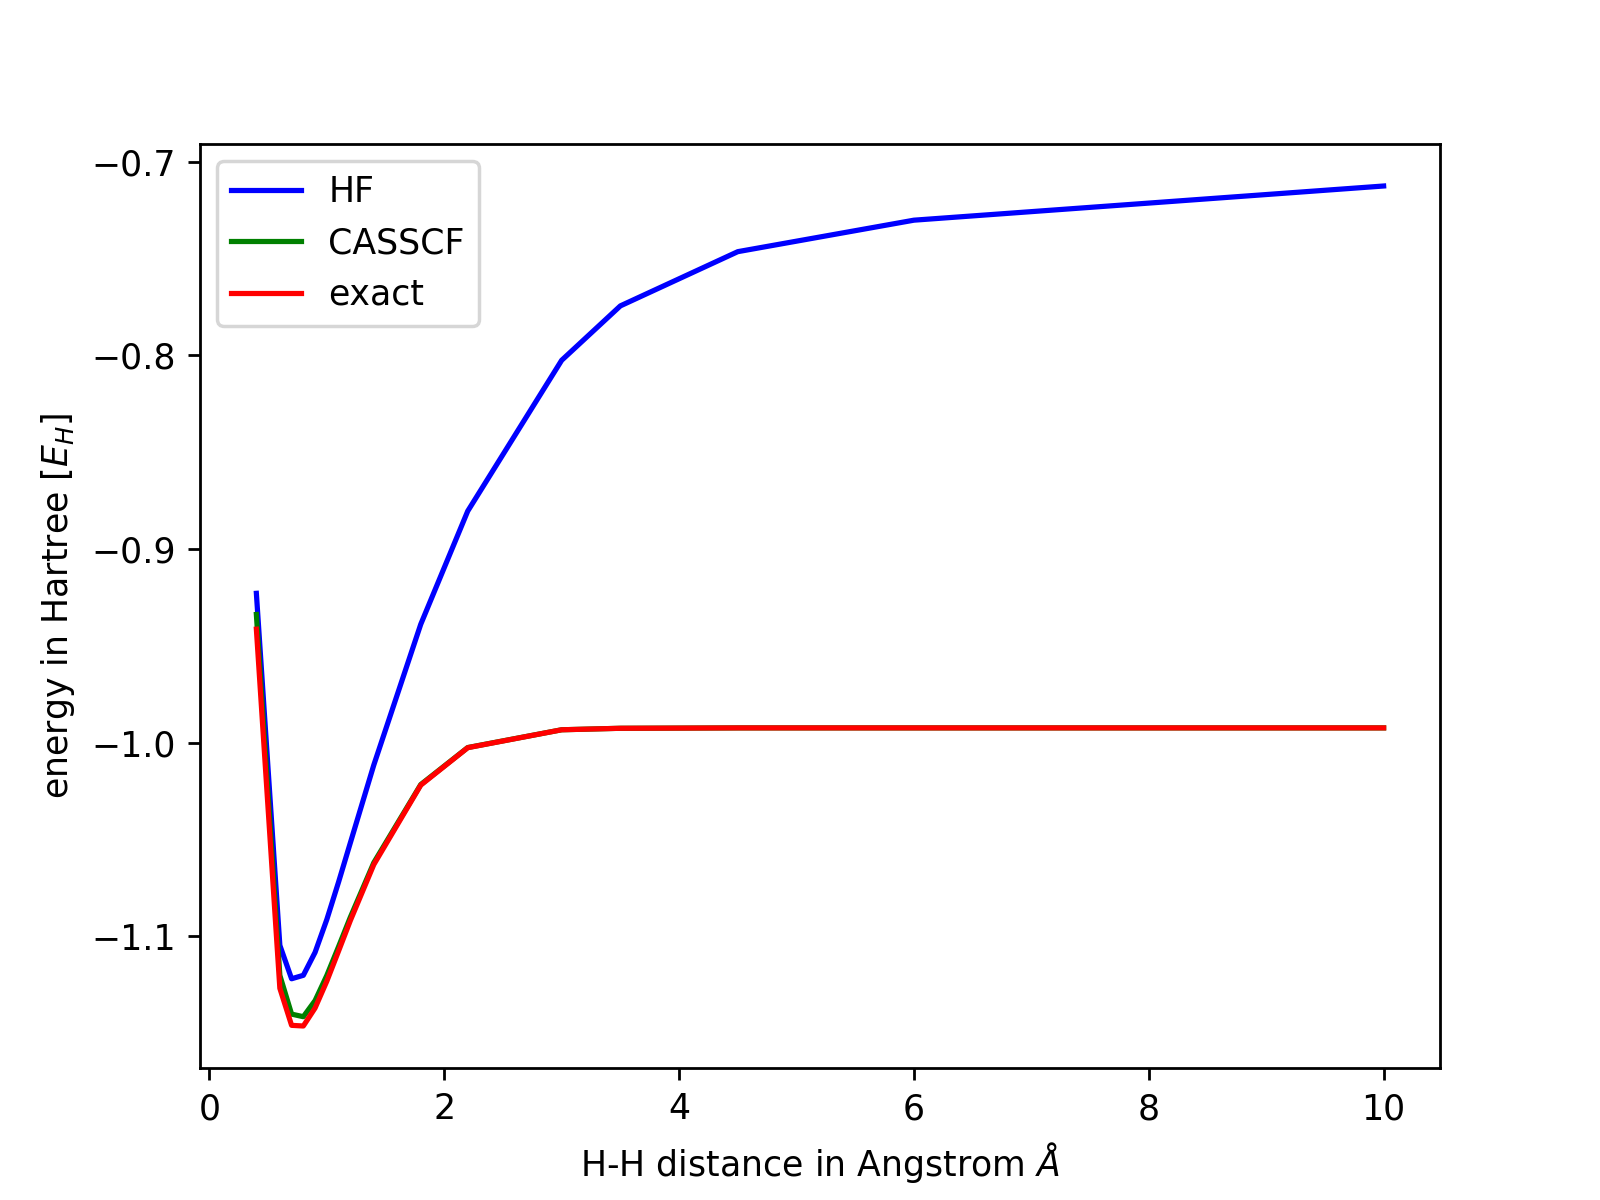

In [8]:
%matplotlib notebook
plt.plot(distances, E_HF,'b',label='HF')
plt.plot(distances, E_CASSCF, 'g', label='CASSCF')
plt.plot(distances, E_exact,'r',label='exact')
plt.legend()
plt.xlabel('H-H distance in Angstrom $\AA$')
plt.ylabel('energy in Hartree [$E_H$]')